<a href="https://colab.research.google.com/github/RLR-GitHub/MultilayerPerceptron/blob/master/trials/MLP_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import random, seed, uniform

# VARIABLES

In [0]:
# N = 2 AND J = 50 AND M = 900 IS GREAT RESULTS
# N = 2 AND J = 30 AND M = 900 IS EVEN BETTER RESULTS
# N = 2 AND J = 30 AND M = 2500 AND E =100 IS EVEN BETTER RESULTS
# N = 2 AND J = 16 AND M = 1600 AND E =2000 AND LR = 1.5 IS EVEN BETTER RESULTS

N = 2           # Number of inputs -- x point, y point
I = N + 1
J = 10           # Number of hidden neurons
K = 1           # Number of output neurons 
M = 225         # 10 x 10 -- Number of training patterns (input/output pairs) - Number of red and blue dots within image that is visable to network -- needs to be less than size of image
MTEST = 225     # 20 x 20 -- Number of test set inputs
EPOCHS = 100    # Complete training set pass-throughs
LEARNING_RATE = 0.5        # learning rate (rho )

# Setup Matrices

In [0]:
# TRAINING
X_train = np.zeros( shape = ( M, I ) )    # 100 x 2 -- shape = ( r, c ) Training set inputs 
Y_train = np.zeros( shape = ( M, K ) )    # 100 x 1 -- shape = ( r, c ) Training set output vector 
D_train = np.zeros( shape = ( M, K ) )    # 100 x 1 -- shape = ( r, c ) Training set target vector

# TESTING
X_test = np.zeros( shape = ( MTEST, I ) ) # 400 x 2 -- shape = ( r, c ) Test set inputs 
Y_test = np.zeros( shape = ( MTEST, K ) ) # 400 x 1 -- shape = ( r, c ) Test set output vector 
D_test = np.zeros( shape = ( MTEST, K ) ) # 400 x 1 -- shape = ( r, c ) Test set target vector

x = np.zeros( shape = ( I ) ) # 2 -- A single input vector from training set 
y = np.zeros( shape = ( K ) ) # 1 -- Single vector of outupt neurons 
d = np.zeros( shape = ( K ) ) # 1 -- A single target vector from training set 
z = np.zeros( shape = ( J ) ) # 8 -- Vector of hidden layer neurons 

# WEIGHTS
V = np.zeros( shape = ( J, I ) ) # 8 x 2 -- Weight matrix for hidden layer 1
W = np.zeros( shape = ( K, J ) ) # 1 x 8 -- Weight matrix for hidden layer 2

delta = np.zeros( shape = ( K ) ) 
delta_V = np.zeros( shape = ( J, I ) ) # 8 x 2 -- Weight changes for hidden layer 1
delta_W = np.zeros( shape = ( K, J ) ) # 1 x 8 -- Weight changes for hidden layer 2

# OUTPUTS
h = np.zeros( shape = ( J ) ) # 8 -- Weighted sum of hidden layer ( Z )
o = np.zeros( shape = ( K ) ) # 1 -- Weiughted sum of output layer ( Y )

# FUNCTIONS

In [0]:
def randomMatrix( matrix, min_val, max_val, bias = False ):
    r, c = matrix.shape
    random_matrix = np.random.uniform( low = min_val, high = max_val, size = ( r, c ) )
    if( bias == True ): 
        for i in range( r ): random_matrix[ i ][ c - 1 ] = 1
    return( random_matrix )

# Dot Product -- Multiply each of the features with a weight and compute the sum
def dotProduct( matrix, vector ):
    dot_matrix = np.dot( matrix, vector )
    return( dot_matrix )
#==================================================================
def trainingInputs( matrix ): ### MAY BE WRONG
    training_matrix = randomMatrix( matrix, -1.0, 1.0, bias = True )
    return( training_matrix )

def testingInputs( matrix ):
    inc = 0
    r, c = matrix.shape
    numSides = math.sqrt( r )
    step = 2 / ( numSides - 1 )

    for i in range( r ):
        if( ( i % numSides == 0 ) and ( i != 0 ) ): inc = inc + 1
        matrix[ i ][ 1 ] = 1.0 - step * inc               # values from 1 to -1
        matrix[ i ][ 0 ] = -1.0 + step * ( i % numSides ) # values from -1 to 1
        matrix[ i ][ 2 ] = 1
    return( matrix )

def targetOutputs( targets, inputs, area ):
    radius = math.sqrt( area / math.pi )
    r, c = targets.shape

    for i in range( r ):
        radii = math.sqrt( ( inputs[ i ][ 0 ] * inputs[ i ][ 0 ] ) + ( inputs[ i ][ 1 ] * inputs[ i ][ 1 ] ) )
        if( radii <= radius ): targets[ i ][ 0 ] = 1#int( True )
        else: targets[ i ][ 0 ] = 0#int( False )

    return( targets )
#==================================================================
def sigmoidActivation( net ):
    n = net.size
    sig_vec = np.zeros( shape = ( n ) )

    for i in range( n ):
        #sigmoid = ( 1.0 / ( 1 + math.exp( -1 * net[ i ] ) ) )
        #if( sigmoid >= 0.5 ): sig_vec[ i ] = 1.0
        #if( sigmoid <  0.5 ): sig_vec[ i ] = 0.0
        sig_vec[ i ] = 1 / ( 1 + math.exp( -1 * net[ i ] ) )
    
    return( sig_vec )


def weightChanges_W( delta, z, lr = LEARNING_RATE ):
    delta_W = np.zeros( shape = ( K, J ) )

    for j in range( J ): 
        d_w = lr * delta * z[ j ] 
        delta_W[ 0 ][ j ] = d_w#np.round( d_w, 8 )

    return( delta_W )

def weightChanges_V( W, delta, z, x, lr = LEARNING_RATE ):
    delta_V = np.zeros( shape = ( J, I ) )

    for j in range( J ):
        summation = delta * W[ 0 ][ j ]
        for i in range( I ):
            # Derivation of y * ( 1 - Y ) helps smooth out sigmoid curve jerking
            d_v = lr * z[ j ] * ( 1 - z[ j ] ) * x[ i ] * summation 
            delta_V[ j ][ i ] = d_v#np.round( d_v, 8 )
    return( delta_V )

def updateWeights( delta_matrix, matrix ):
    r, c = matrix.shape
    
    for i in range( r ): 
        for j in range( c ): 
            matrix[ i ][ j ] = delta_matrix[ i ][ j ] + matrix[ i ][ j ]

    return( matrix )
#==================================================================

def printMatrix( matrix, mat2, string ):
    size = matrix.size 
    fig, ax = plt.subplots( figsize = ( 5,5 ) )
    ax.set_ylim( [ -1, 1 ] )
    ax.set_xlim( [ -1, 1 ] )
    ax.set_title( string, va = 'bottom' )
    for r in range( size ):
        val = int( round( matrix[ r ][ 0 ] ) )
        if( val == 1 ): ax.text( mat2[ r ][0], mat2[r][1], str( val ), va = 'center', ha = 'center', c = 'r' )
        if( val == 0 ): ax.text( mat2[ r ][0], mat2[r][1], str( val ), va = 'center', ha = 'center', c = 'b' )

# TRAINING PHASE

In [0]:
# GET TRAINING PATTERN VALUES 
X_train = trainingInputs( X_train ) # random points in [-1,1]x[-1,1]
D_train = targetOutputs( D_train, X_train, area = 2.0 )

# INITIALIZE WEIGHT MATRICIES 
V = randomMatrix( V, -10.0, 10.0) # Weight matrix to the hidden layer
W = randomMatrix( W, -10.0, 10.0) # Weight matrix to the output layer 

In [0]:
print( h ) 
print( "\nZ",z )
print( "\nO",o ) 
print( "\nY",y )
print( "\nD",d )

print( "\ndelta", delta )
print( "\nE",E )

print( V )
print( "\n",W )

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Z [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

O [0.]

Y [0.]

D [0.]

delta [0.]

E [4.88498131e-15]
[[-0.10707143  1.13339672 -9.25988769]
 [ 6.71902067  1.3581224  -7.59748919]
 [-7.58230592 -0.9230931   0.42093763]
 [ 3.76968817 -4.52882143  6.44714552]
 [ 5.86967935 -5.38317178 -8.20135339]
 [-8.60719319 -1.4689256  -1.25903195]
 [ 8.7878865   2.93052642 -0.67958479]
 [ 8.24057137 -2.32308188 -9.52101705]
 [ 1.7562473   7.49187691 -8.90201363]
 [-9.76169528  4.99128667  5.00472366]]

 [[ 3.8704239   0.97862582 -1.51990146 -5.95682146 -2.22083366  7.08178623
  -0.56300849  0.98605977  3.08927918 -5.18469514]]


In [0]:
count = 0
new_lr = 0.75
old_best_err_val = 10000000

for epoch in range( 1000 ):

    Error = 0.0 
    for m in range( M ): 

        # FORWARD PASS
        
        x = X_train[ m ][ : ]                       # Get mth row of X
        d = D_train[ m ][ : ]                       # Get mth row of D 

        h = dotProduct( V, x )       # Get weighted sums of hidden layer 
        z = sigmoidActivation( h )               # Get weighted outputs of hidden layer 
        o = dotProduct( W, z )       # Get weighted sums of output layer 
        y = sigmoidActivation( o )

        Y_train[ m ] = y

        # BACKWARD PASS

        E = ( d - y )                                        # Gradient of error 
        delta = E * y * ( 1 - y )                           # Chnage factor (delta) at output layer       
        #delta = E * E            
        #if( E == 0 ): delta = 0
        #else: delta = 0.25
        Error = Error + ( E * E ) / 2                       # Actual error: mean square loss
        #if( int(y) == 1 ): Error = Error - np.log( E )
        #if( int(y) == 0 ): Error = Error - np.log( 1 - E )

        delta_W = weightChanges_W( delta, z, new_lr )           # Compute weight changes of W 
        delta_V = weightChanges_V( W, delta, z, x, new_lr )     # Compute weight changes of V

        W = updateWeights( delta_W, W )                       # Compute weight update of W 
        V = updateWeights( delta_V, V )                       # Compute weight update of V
        
        #print( "Error Gradient: {0:8f}".format( float( E ) ), "d: {0:5f}".format( float( d ) ), "y: {0:5f}".format( float( y ) ) )
    if( ( epoch + 1 ) % 20 == True ): print( "Epoch: {0:4d}\t".format( int( epoch ) ), "Error: {0:8}\t".format( float( Error ) ), "LR: {0:5f}".format( float( new_lr ) ) )
    if( float( Error ) <= float( old_best_err_val ) ): 
        old_best_err_val = Error 
        count = 0
    else: 
        count = count + 1
        if( count >= 200 ): 
            new_lr = new_lr * 0.95
            print( "LEARNING RATE CHANGE:", new_lr )
            count = 0

Epoch:    0	 Error: 56.0033453650122	 LR: 0.750000
Epoch:   20	 Error: 13.990733643641603	 LR: 0.750000
Epoch:   40	 Error: 10.105331511267252	 LR: 0.750000
Epoch:   60	 Error: 9.217686892561762	 LR: 0.750000
Epoch:   80	 Error: 8.534535973618066	 LR: 0.750000
Epoch:  100	 Error: 7.972640263169514	 LR: 0.750000
Epoch:  120	 Error: 7.191577764745732	 LR: 0.750000
Epoch:  140	 Error: 6.469667006063055	 LR: 0.750000
Epoch:  160	 Error: 5.967693310861349	 LR: 0.750000
Epoch:  180	 Error: 5.454634562562485	 LR: 0.750000
Epoch:  200	 Error: 5.115614245365689	 LR: 0.750000
Epoch:  220	 Error: 4.866463471800389	 LR: 0.750000
Epoch:  240	 Error: 4.717939482086808	 LR: 0.750000
Epoch:  260	 Error: 4.405021302471988	 LR: 0.750000
Epoch:  280	 Error: 3.9346174270134107	 LR: 0.750000
Epoch:  300	 Error: 3.6199442194481932	 LR: 0.750000
Epoch:  320	 Error: 3.4572341203391024	 LR: 0.750000
Epoch:  340	 Error: 3.0632282702237643	 LR: 0.750000
Epoch:  360	 Error: 3.1580204789707755	 LR: 0.750000
Epoch:

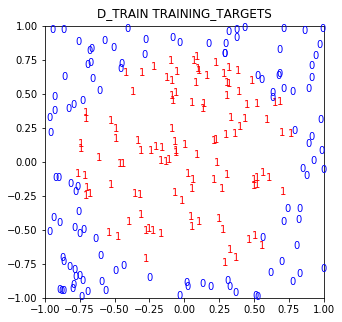

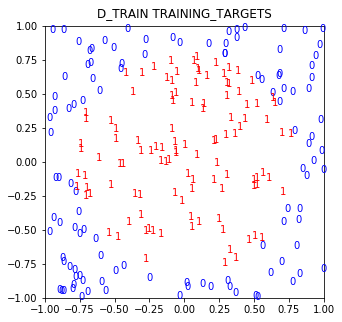

In [0]:
printMatrix( Y_train, X_train, "D_TRAIN TRAINING_TARGETS" )
printMatrix( D_train, X_train, "D_TRAIN TRAINING_TARGETS" ) 

# TESTING PHASE

TestSet Error: 2.3932153256124216


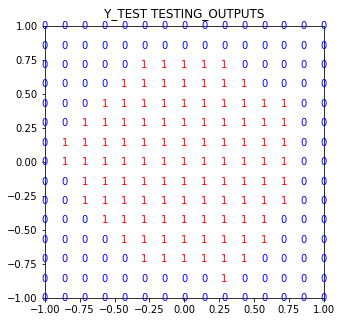

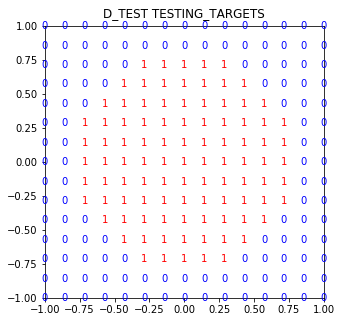

In [0]:
# GET TESTING PATTERN VALUES 
X_test = testingInputs( X_test )
D_test = targetOutputs( D_test, X_test, area = 2.0 )

Error = 0.0
for m in range( MTEST ): 

    x = X_test[ m ][ : ]                       # Get mth row of X
    d = D_test[ m ][ : ]                       # Get mth row of D 
    h = dotProduct( V, x )                     # Get weighted sums of hidden layer 
    z = sigmoidActivation( h )                 # Get weighted outputs of hidden layer 
    o = dotProduct( W, z )                     # Get weighted sums of output layer 
    y = sigmoidActivation( o )                 # Get weighted outputs of output layer 
    Error = Error + ( d - y ) * ( d - y ) / 2  # Actual error: mean square loss
    Y_test[ m ] = y

print( "TestSet Error:", float( Error ) )

printMatrix(  Y_test,  X_test, "Y_TEST TESTING_OUTPUTS" )
printMatrix(  D_test,  X_test, "D_TEST TESTING_TARGETS" )